<font size="+3"><strong>7.5. Admissions in the MScFE 🎓🗞</strong></font>

In this project, you conducted an experiment to help WQU improve enrollment in the Applied Data Science Lab. But let's not forget about our [Master of Science in Financial Engineering](https://www.wqu.edu/programs/mscfe/)! For your assignment, you'll help the MScFE conduct a similar experiment. This will be a great opportunity to put your new EDA, ETL, and statistics skills into action. 

Also, keep in mind that for many of these submissions, you'll be passing in dictionaries that will test different parts of your code. 

In [121]:
import wqet_grader
from pymongo import MongoClient
from pymongo.collection import Collection
from teaching_tools.ab_test.reset import Reset

wqet_grader.init("Project 7 Assessment")

r = Reset()
r.reset_database()

Reset 'ds-applicants' collection. Now has 5025 documents.
Reset 'mscfe-applicants' collection. Now has 1335 documents.


In [122]:
# Import your libraries here
from pprint import PrettyPrinter
import math
import numpy as np
import pandas as pd
import plotly.express as px
from country_converter import CountryConverter
from statsmodels.stats.power import GofChisquarePower
import scipy
from statsmodels.stats.contingency_tables import Table2x2
from teaching_tools.ab_test.experiment import Experiment
import pandas as pd
from country_converter import CountryConverter
from pymongo import MongoClient


# Connect

**Task 7.5.1:** On your MongoDB server, there is a collection named `"mscfe-applicants"`. Locate this collection, and assign it to the variable name `mscfe_app`.

In [81]:
from pymongo import MongoClient
# Create `client`
client = MongoClient(host="localhost", port=27017)
# Create `db`
db = client ["wqu-abtest"]
# Assign `"mscfe-applicants"` collection to `mscfe_app`
mscfe_app = db["mscfe-applicants"]

In [82]:
submission = {
    "is_collection": isinstance(mscfe_app, Collection),
    "collection_name": mscfe_app.full_name,
}
wqet_grader.grade("Project 7 Assessment", "Task 7.5.1", submission)

# Explore

**Task 7.5.2:** Aggregate the applicants in `mscfe_app` by nationality, and then load your results into the DataFrame `df_nationality`. Your DataFrame should have two columns: `"country_iso2"` and `"count"`.

In [83]:
# Aggregate applicants by nationality
result = mscfe_app.aggregate(
    [
        {
            "$group": {
                "_id": "$countryISO2", "count": {"$count": {}}
            }
        }
    ]
)
print("result type:", type(result))

# Load result into DataFrame
df_nationality =  ( 
    pd.DataFrame(result).rename({"_id": "country_iso2"}, axis="columns").sort_values("count")
)

print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()

result type: <class 'pymongo.command_cursor.CommandCursor'>
df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (100, 2)


,country_iso2,count
83,TW,1
54,AO,1
87,NL,1
50,GY,1
24,SN,1


In [84]:
wqet_grader.grade("Project 7 Assessment", "Task 7.5.2", df_nationality)


**Task 7.5.3:** Using the `country_converter` library, add two new columns to `df_nationality`. The first, `"country_name"`, should contain the short name of the country in each row. The second, `"country_iso3"`, should contain the three-letter abbreviation.

In [85]:
# Instantiate `CountryConverter`


# Create `"country_name"` column
cc = CountryConverter()
df_nationality["country_name"] = cc.convert(
    df_nationality["country_iso2"], to="name_short"
)
df_nationality["country_iso3"] = cc.convert(
    df_nationality["country_iso2"], to="ISO3"
)
# Create `"country_iso3"` column


print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()

df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (100, 4)


,country_iso2,count,country_name,country_iso3
83,TW,1,Taiwan,TWN
54,AO,1,Angola,AGO
87,NL,1,Netherlands,NLD
50,GY,1,Guyana,GUY
24,SN,1,Senegal,SEN


In [86]:
wqet_grader.grade("Project 7 Assessment", "Task 7.5.3", df_nationality)


**Task 7.5.4:** Build a function `build_nat_choropleth` that uses plotly express and the data in `df_nationality` to create a choropleth map of the nationalities of MScFE applicants. Be sure to use the title `"MScFE Applicants: Nationalities"`.

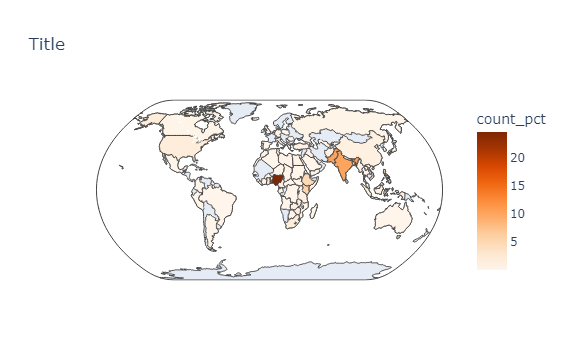

In [87]:
# Create `build_nat_choropleth` function
df_nationality["count_pct"] = (df_nationality["count"] / df_nationality["count"].sum()) * 100


def build_nat_choropleth():
    fig = px.choropleth(
        data_frame= df_nationality,
        locations="country_iso3",
        color="count_pct",
        projection="natural earth",
        color_continuous_scale=px.colors.sequential.Oranges,
        title="Title"
    )
    return fig

# Don't delete the code below 👇
nat_fig = build_nat_choropleth()
nat_fig.write_image("images/7-5-4.png", scale=1, height=500, width=700)

nat_fig.show()

In [88]:
with open("images/7-5-4.png", "rb") as file:
    wqet_grader.grade("Project 7 Assessment", "Task 7.5.4", file)

# ETL

In this section, you'll build a `MongoRepository` class. There are several tasks that will evaluate your class definition. You'll write your code in the cell below, and then submit each of those tasks one-by-one later on. 

In [89]:
class MongoRepository:
    """Repository class for interacting with MongoDB database.

    Parameters
    ----------
    client : `pymongo.MongoClient`
        By default, `MongoClient(host='localhost', port=27017)`.
    db : str
        By default, `'wqu-abtest'`.
    collection : str
        By default, `'mscfe-applicants'`.

    Attributes
    ----------
    collection : pymongo.collection.Collection
        All data will be extracted from and loaded to this collection.
    """

    # Task 7.5.5: `__init__` method
    def __init__(
        self,
        client=MongoClient(host='localhost', port=27017),
        db='wqu-abtest',
        collection="mscfe-applicants"
    ):
        self.collection = client[db][collection]

    # Task 7.5.6: `find_by_date` method
    def find_by_date(self, date_string="2022-06-01"):
        # Convert `date_string` to datetime object
        start = pd.to_datetime(date_string, format='%Y-%m-%d')
        # Offset `start` by 1 day
        end = start + pd.DateOffset(days=1)
        # Create PyMongo query for no-quiz applicants b/t `start` and `end`
        query = {"createdAt": {"$gte": start, "$lt": end}, "admissionsQuiz": "incomplete"}
        # Query collection, get result
        result = self.collection.find(query)
        # Convert `result` to list
        observations = list(result)
        return observations

    # Task 7.5.7: `update_applicants` method
    def update_applicants(self, observations_assigned):
        # Initalize counters
        n = 0
        n_modified = 0

        # Itearate through applicants
        for doc in observations_assigned:
            # Update doc
            result = self.collection.update_one(
                filter={'_id': doc['_id']},
                update={'$set':doc}
            )
            # Update counters
            n += result.matched_count
            n_modified += result.modified_count

        # Create results
        transaction_result ={'n':n, 'nModified':n_modified}
        return transaction_result

    # Task 7.5.7: `assign_to_groups` method
    def assign_to_groups(self, date_string="2022-06-02"):
        # Get observations
        observations = self.find_by_date(date_string)
        # Shuffle `observations`
        #random.seed(42)
        #random.shuffle(observations)

        # Get index position of item at observations halfway point
        idx = len(observations) // 2

        # Assign first half of observations to control group
        for doc in observations[:idx]:
            doc['inExperiment'] = True
            doc['group'] = 'no email (control)'

        # Assign second half of observations to treatment group
        for doc in observations[idx:]:
            doc['inExperiment'] = True
            doc['group'] = 'email (treatment)'
        # update collection
        result = self.update_applicants(observations)
        return result

    # Task 7.5.14: `find_exp_observations` method
    def find_exp_observations(self):
        # Get observations from database
        result = self.collection.find({'inExperiment': True})
        return list(result)

**Task 7.5.5:** Create a class definition for your `MongoRepository`, including an `__init__` function that will assign a `collection` attribute based on user input. Then create an instance of your class named `repo`. The grader will test whether `repo` is associated with the correct collection. 

In [90]:
from pymongo import MongoClient
# class MongoRepository:
#     def __init__():
        
repo =  MongoRepository()
print("repo type:", type(repo))
repo

repo type: <class '__main__.MongoRepository'>


In [91]:
submission = {
    "is_mongorepo": isinstance(repo, MongoRepository),
    "repo_name": repo.collection.name,
}
submission
wqet_grader.grade("Project 7 Assessment", "Task 7.5.5", submission)

**Task 7.5.6:** Add a `find_by_date` method to your class definition for `MongoRepository`. The method should search the class collection and return all the no-quiz applicants from a specific date. The grader will check your method by looking for applicants whose accounts were created on **1 June 2022**.

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> Once you update your class definition above, you'll need to rerun that cell and then re-instantiate <code>repo</code>. Otherwise, you won't be able to submit to the grader for this task.
</div>

In [92]:
submission = wqet_grader.clean_bson(repo.find_by_date("2022-06-01"))
wqet_grader.grade("Project 7 Assessment", "Task 7.5.6", submission)

**Task 7.5.7:** Add an `assign_to_groups` method to your class definition for `MongoRepository`. It should find users from that date, assign them to groups, update the database, and return the results of the transaction. In order for this method to work, you may also need to create an `update_applicants` method, too. 

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> Once you update your class definition above, you'll need to rerun that cell and then re-instantiate <code>repo</code>. Otherwise, you won't be able to submit to the grader for this task.
</div>

In [94]:
date = "2022-06-02"
repo.assign_to_groups(date)
submission = wqet_grader.clean_bson(repo.find_by_date(date))
wqet_grader.grade("Project 7 Assessment", "Task 7.5.7", submission)

# Experiment

## Prepare Experiment

**Task 7.5.8:** First, instantiate a `GofChisquarePower` object and assign it to the variable name `chi_square_power`. Then use it to calculate the `group_size` needed to detect a **medium** effect size of `0.5`, with an alpha of `0.05` and power of `0.8`.

In [95]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(
    chi_square_power.solve_power(effect_size=0.5, alpha=0.05, power=0.8)
)

print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 32
Total # of applicants needed: 64


In [96]:
# DREW: The submission should be `[group_size]` with tolerance of 0.02
wqet_grader.grade("Project 7 Assessment", "Task 7.5.8", [group_size])

**Task 7.5.9:** Calculate the number of no-quiz accounts were created each day included in the `mscfe_app` collection. The load your results into the Series `no_quiz_mscfe`. 

In [97]:
# Aggregate no-quiz applicants by sign-up date
result = mscfe_app.aggregate(
    [
        {'$match': {'admissionsQuiz': 'incomplete'}},
        {
            '$group':{
                '_id': {'$dateTrunc': {'date': '$createdAt', 'unit': 'day'}},
                'count': {'$sum': 1}
            }
        }
    ]
)



# Load result into DataFrame
no_quiz_mscfe =  (
    pd.DataFrame(result)
    .rename({'_id':'date', 'count': 'new_users'}, axis=1)
    .set_index('date')
    .sort_index()
    .squeeze()
)


print("no_quiz type:", type(no_quiz_mscfe))
print("no_quiz shape:", no_quiz_mscfe.shape)
no_quiz_mscfe.head()

no_quiz type: <class 'pandas.core.series.Series'>
no_quiz shape: (30,)


date
2022-06-01    20
2022-06-02     9
2022-06-03    12
2022-06-04    15
2022-06-05    11
Name: new_users, dtype: int64

In [98]:
wqet_grader.grade("Project 7 Assessment", "Task 7.5.9", no_quiz_mscfe)


**Task 7.5.10:** Calculate the mean and standard deviation of the values in `no_quiz_mscfe`, and assign them to the variables `mean` and `std`, respectively.

In [99]:
mean = no_quiz_mscfe.describe()['mean']
std = no_quiz_mscfe.describe()['std']
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 12.133333333333333
no_quiz std: 3.170264139254595


In [100]:
submission = {"mean": mean, "std": std}
submission
wqet_grader.grade("Project 7 Assessment", "Task 7.5.10", submission)

**Ungraded Task:** Complete the code below so that it calculates the mean and standard deviation of the probability distribution for the total number of days assigned to `exp_days`.

In [101]:
exp_days =  7
sum_mean =  mean * exp_days
sum_std =std * np.sqrt(exp_days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 84.93333333333334
Std of sum: 8.3877305028539


**Task 7.5.11:** Using the `group_size` you calculated earlier and the code you wrote in the previous task, determine how many days you must run your experiment so that you have a 95% or greater chance of getting a sufficient number of observations. Keep in mind that you want to run your experiment for the fewest number of days possible, and no more. 

In [102]:
prob_65_or_fewer = scipy.stats.norm.cdf(
    group_size * 2,
    loc=sum_mean,
    scale=sum_std
)
prob_65_or_greater = 1 - prob_65_or_fewer

print(
    f"Probability of getting 65+ no_quiz in {exp_days} days:",
    round(prob_65_or_greater, 3),
)

Probability of getting 65+ no_quiz in 7 days: 0.994


In [103]:
submission = {"days": exp_days, "probability": prob_65_or_greater}
submission
wqet_grader.grade("Project 7 Assessment", "Task 7.5.11", submission)

## Run Experiment

**Task 7.5.12:** Using the `Experiment` object created below, run your experiment for the appropriate number of days.

In [104]:
exp = Experiment(repo=client, db="wqu-abtest", collection="mscfe-applicants")
exp.reset_experiment()
result = exp.run_experiment(days=exp_days, assignment=True)
print("result type:", type(result))
result

result type: <class 'dict'>


{'acknowledged': True, 'inserted_count': 301}

In [105]:
wqet_grader.grade("Project 7 Assessment", "Task 7.5.12", result)

## Analyze Results

**Task 7.5.13:** Add a `find_exp_observations` method to your `MongoRepository` class. It should return all the observations from the class collection that were part of the experiment.

<div class="alert alert-block alert-warning">
<p><b>Warning:</b> Once you update your class definition above, you'll need to rerun that cell and then re-instantiate <code>repo</code>. Otherwise, you won't be able to submit to the grader for this task.
</div>

In [120]:
submission = wqet_grader.clean_bson(repo.find_exp_observations())
wqet_grader.grade("Project 7 Assessment", "Task 7.5.13", submission)

**Task 7.5.14:** Using your `find_exp_observations` method load the observations from your `repo` into the DataFrame `df`.

In [108]:
result = repo.find_exp_observations()
df = pd.DataFrame(result).dropna()


print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (83, 12)


,_id,createdAt,firstName,lastName,email,birthday,gender,highestDegreeEarned,countryISO2,admissionsQuiz,inExperiment,group
0,634b6ff96fcaafb2130fb51f,2022-10-22 11:01:04,Bradley,Krasley,bradley.krasley57@microsift.com,1995-06-18,male,Bachelor's degree,CN,complete,True,email (t)
1,634b6ff96fcaafb2130fb520,2022-10-19 12:36:46,Andrew,Womack,andrew.womack91@microsift.com,2000-03-17,male,Master's degree,GH,complete,True,email (t)
2,634b6ff96fcaafb2130fb521,2022-10-16 23:46:25,Michael,Smith,michael.smith51@microsift.com,1995-08-29,male,Doctorate (e.g. PhD),UG,complete,True,email (t)
3,634b6ff96fcaafb2130fb526,2022-10-22 01:26:40,Alex,Hachting,alex.hachting27@hotmeal.com,1998-03-21,male,Bachelor's degree,IN,complete,True,email (t)
4,634b6ff96fcaafb2130fb52b,2022-10-16 13:40:05,Jerry,Neilan,jerry.neilan81@microsift.com,1972-07-02,male,Master's degree,LB,complete,True,email (t)


In [109]:
# DREW: This should check column names only
wqet_grader.grade("Project 7 Assessment", "Task 7.5.14", df.drop(columns=["_id"]))


**Task 7.5.15:** Create a `crosstab` to of the data in `df`, showing how many applicants in each experimental group did and did not complete the admissions quiz. Assign the result to `data`.

In [110]:
data = pd.crosstab(
    index=df['group'],
    columns=df['admissionsQuiz'],
    normalize=False
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (t),8,33
no email (c),2,40


In [111]:
wqet_grader.grade("Project 7 Assessment", "Task 7.5.15", data)


**Task 7.5.16:** Create a function that returns side-by-side bar chart of `data`, showing the number of complete and incomplete quizzes for both the treatment and control groups. Be sure to label the x-axis `"Group"`, the y-axis `"Frequency [count]"`, and use the title `"MScFE: Admissions Quiz Completion by Group"`.

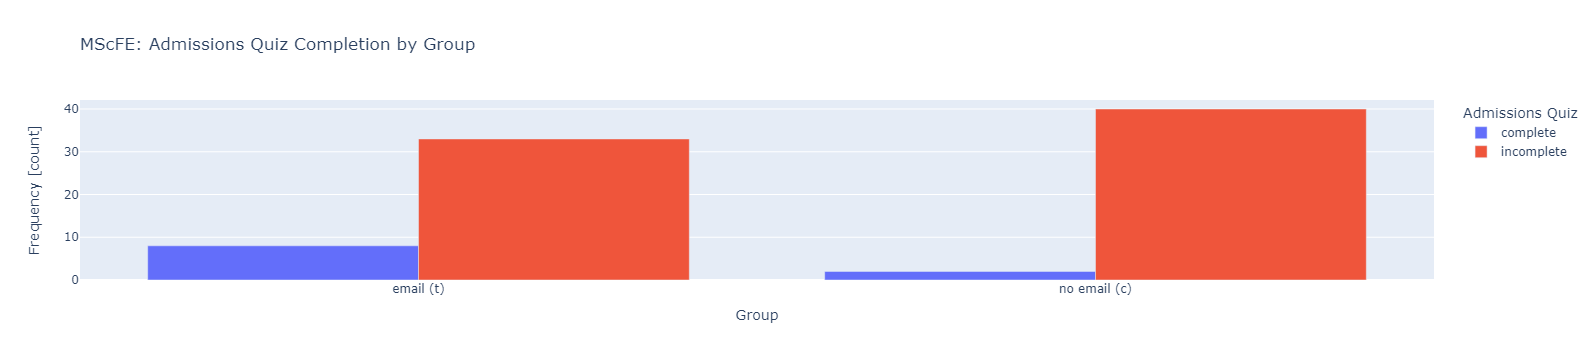

In [112]:
# Create `build_contingency_bar` function
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame=data,
        barmode='group',
        title="MScFE: Admissions Quiz Completion by Group"
    )
    # Set axis labels
    fig.update_layout(
        xaxis_title='Group',
        yaxis_title='Frequency [count]',
        legend={'title': 'Admissions Quiz'}
    )
    return fig

# Don't delete the code below 👇
cb_fig = build_contingency_bar()
cb_fig.write_image("images/7-5-16.png", scale=1, height=500, width=700)

cb_fig.show()

In [113]:
with open("images/7-5-16.png", "rb") as file:
    wqet_grader.grade("Project 7 Assessment", "Task 7.5.16", file)

**Task 7.5.17:** Instantiate a `Table2x2` object named `contingency_table`, using the values from the `data` you created above.

In [114]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig

contingency_table type: <class 'statsmodels.stats.contingency_tables.Table2x2'>


array([[ 8, 33],
       [ 2, 40]])

In [115]:
submission = contingency_table.table_orig.tolist()
wqet_grader.grade("Project 7 Assessment", "Task 7.5.17", submission)

**Task 7.5.18:** Perform a chi-square test of independence on your `contingency_table` and assign the results to `chi_square_test`.

In [116]:
chi_square_test = contingency_table.test_nominal_association()

print("chi_square_test type:", type(chi_square_test))
print(chi_square_test)

chi_square_test type: <class 'statsmodels.stats.contingency_tables._Bunch'>
df          1
pvalue      0.039024446016475034
statistic   4.259803032472594


In [117]:
submission = {"p-value": chi_square_test.pvalue, "statistic": chi_square_test.statistic}
submission
wqet_grader.grade("Project 7 Assessment", "Task 7.5.18", submission)

**Task 7.5.19:** Calculate the odds ratio for your `contingency_table`.

In [118]:
odds_ratio = contingency_table.oddsratio.round(1)
print("Odds ratio:", odds_ratio)

Odds ratio: 4.8


In [119]:
submission = {"odds ratio": odds_ratio}
submission
wqet_grader.grade("Project 7 Assessment", "Task 7.5.19", submission)

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
